In [14]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
#from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import seaborn as sns

In [15]:
def flatten_dict(d, parent_key='', sep='_'):
    items = {}
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_dict(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

# Opening JSON file
f = open('port_arthur.json')
 
# returns JSON object as a dictionary
data = json.load(f)
 
# Flatten each dictionary and store the results in a list
flattened_dicts = [flatten_dict(d) for d in data['data']]

# Create a DataFrame
data = pd.DataFrame(flattened_dicts)

# Print the DataFrame
#print(data)

 
# Closing file
f.close()

In [16]:
data['navigation_time'] = pd.to_datetime(data['navigation_time'])

data = data.drop_duplicates()

data

,vessel_type,vessel_callsign,vessel_subtype,vessel_imo,vessel_name,navigation_draught,navigation_status,navigation_location_long,navigation_location_lat,navigation_speed,navigation_time,navigation_course,device_mmsi,device_dimensions_to_bow,device_dimensions_to_starboard,device_dimensions_to_stern,device_dimensions_to_port
0,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70755,29.41630,0.7,2021-04-07 16:01:55+00:00,45.9,224941000,226,24,58,19
1,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70643,29.41625,1.4,2021-04-07 16:06:15+00:00,118.6,224941000,226,24,58,19
2,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70459,29.41492,1.2,2021-04-07 16:11:05+00:00,144.9,224941000,226,24,58,19
4,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.70219,29.41087,4.4,2021-04-07 16:21:54+00:00,97.0,224941000,226,24,58,19
5,tanker,EBZV,all,9236420,CATALUNYA SPIRIT,9.6,under-way-using-engine,-93.69435,29.41231,5.8,2021-04-07 16:26:44+00:00,62.8,224941000,226,24,58,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09057,30.07655,0.0,2021-04-08 08:11:46+00:00,277.5,563495000,187,16,26,15
2343,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09055,30.07655,0.0,2021-04-08 08:14:46+00:00,277.5,563495000,187,16,26,15
2344,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09057,30.07657,0.0,2021-04-08 08:20:45+00:00,277.5,563495000,187,16,26,15
2345,cargo,9VAW8,all,9081801,HOSANGER,9.1,moored,-94.09056,30.07656,0.0,2021-04-08 08:26:46+00:00,277.5,563495000,187,16,26,15


In [17]:
tugs = data.loc[(data['vessel_type'] == 'tug')].reset_index()
non_tug = data.loc[(data['vessel_type'] != 'tug')].reset_index()

In [18]:
# Select the columns you want to keep
selected_columns = ['vessel_name','vessel_type', 'device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Create a new DataFrame with only the selected columns
new_data = data.loc[:, selected_columns]


# Group the data by 'vessel_name' and aggregate the values using, for example, 'first' function
aggregated_df = new_data.groupby('vessel_name').first().reset_index()

# Display the aggregated DataFrame
aggregated_df

,vessel_name,vessel_type,device_dimensions_to_bow,device_dimensions_to_starboard,device_dimensions_to_stern,device_dimensions_to_port
0,ALLIANCE NORFOLK,cargo,45,14,154,18
1,ATHENA,tug,10,12,6,12
2,BUCCANEER,tug,15,5,11,5
3,CARIBE LIZA,tanker,109,10,20,10
4,CATALUNYA SPIRIT,tanker,226,24,58,19
5,ENERGY PROGRESS,tanker,146,8,37,24
6,GAS GABRIELA,tanker,194,24,36,8
7,GASLOG GLASGOW,tanker,230,25,60,21
8,HOSANGER,cargo,187,16,26,15
9,IRELAND,cargo,196,23,33,10


In [70]:
# Define custom colors for each vessel type
custom_colors = ['mediumslateblue', 'goldenrod', 'darkgrey']

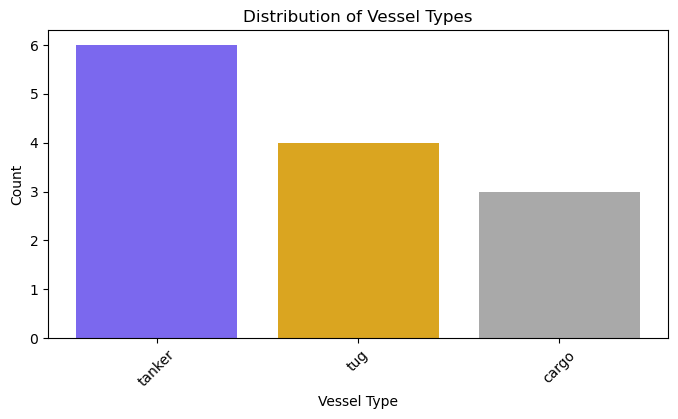

In [71]:
# Count the number of unique vessel types
vessel_type_counts = aggregated_df['vessel_type'].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(vessel_type_counts.index, vessel_type_counts.values, color=custom_colors)
plt.xlabel('Vessel Type')
plt.ylabel('Count')
plt.title('Distribution of Vessel Types')
plt.xticks(rotation=45)
plt.show()

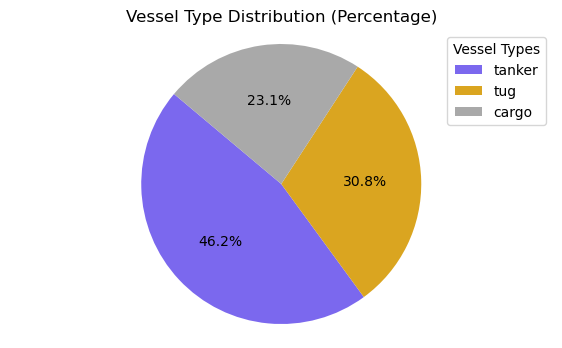

In [72]:
# Count the number of unique vessel types
vessel_type_counts = aggregated_df['vessel_type'].value_counts()

# Define custom colors for each vessel type
#custom_colors = ['lightsalmon', 'lightblue', 'lightcoral']

plt.figure(figsize=(7, 4))
plt.pie(vessel_type_counts, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Vessel Type Distribution (Percentage)')

# Add a legend
plt.legend(vessel_type_counts.index, title='Vessel Types', loc='best')

plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()


/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

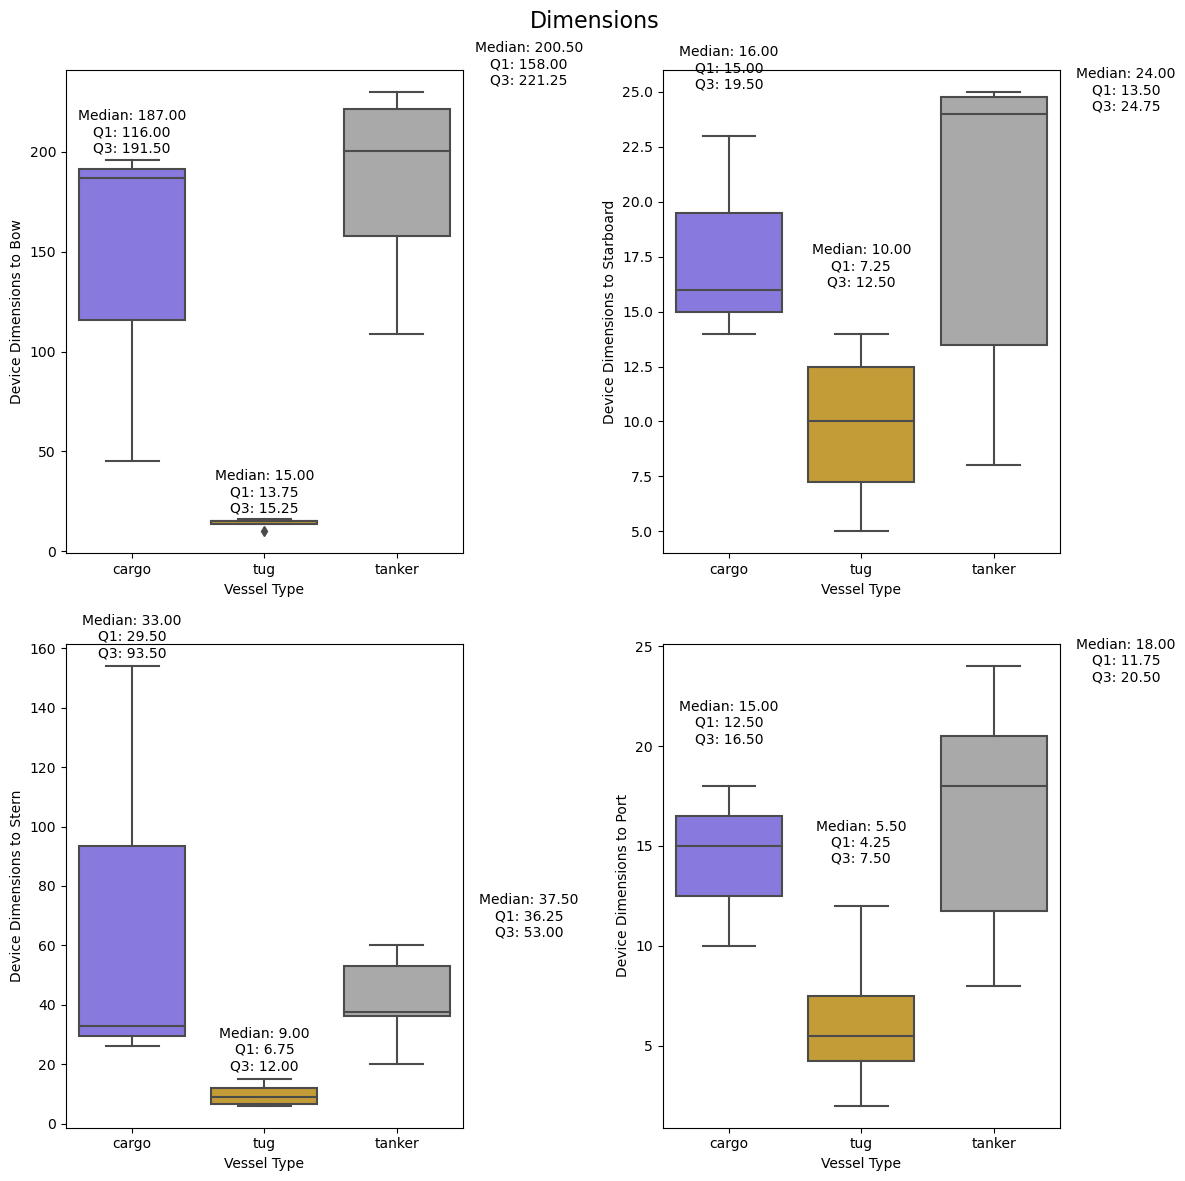

In [73]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# List of dimensions
dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Iterate over dimensions and corresponding subplots
for dimension, ax in zip(dimensions, axes.flatten()):
    # Plot the box plot
    sns.boxplot(data=aggregated_df, x='vessel_type', y=dimension, palette=custom_colors, ax=ax)
    
    # Set labels for the subplot
    ax.set_xlabel('Vessel Type')
    ax.set_ylabel(f'Device Dimensions to {dimension.split("_")[-1].title()}')
    
    # Calculate and display statistical properties
    for vessel_type in aggregated_df['vessel_type'].unique():
        subset_data = aggregated_df[aggregated_df['vessel_type'] == vessel_type]
        median = subset_data[dimension].median()
        q1 = subset_data[dimension].quantile(0.25)
        q3 = subset_data[dimension].quantile(0.75)
        max_val = subset_data[dimension].max()
        
        # Determine the vertical position for labels
        text_y = max_val + 2 if max_val + 2 < ax.get_ylim()[1] else ax.get_ylim()[1] - 2
        
        ax.text(
            subset_data.index[0], 
            text_y, 
            f"Median: {median:.2f}\nQ1: {q1:.2f}\nQ3: {q3:.2f}", 
            horizontalalignment='center', 
            verticalalignment='bottom',
            color='black'
        )

# Set a single title for all subplots
fig.suptitle('Dimensions', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

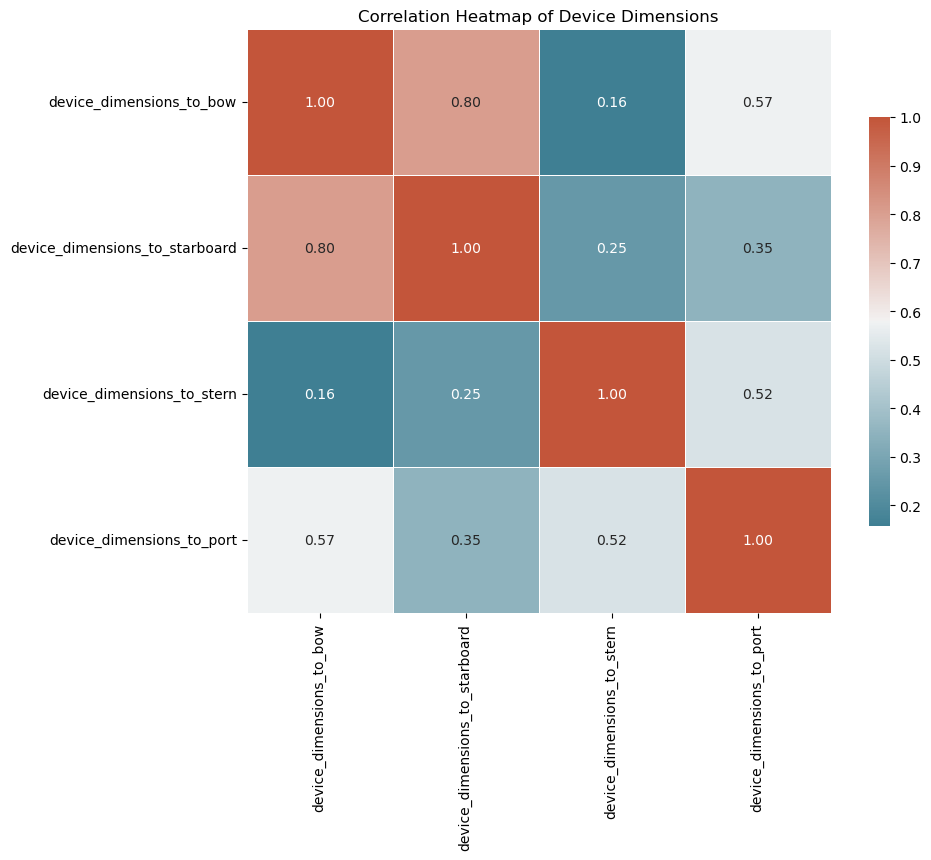

In [78]:

# List of device dimensions
device_dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Calculate the correlation matrix
correlation_matrix = aggregated_df[device_dimensions].corr()

# Create a figure with a larger size
plt.figure(figsize=(10, 8))

# Define a custom color palette for the heatmap
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the correlation heatmap with annotations
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',  # Format for annotation values
    cmap=custom_cmap,
    linewidths=0.5,
    square=True,  # Make the plot square
    cbar=True,  # Display color bar
    cbar_kws={'shrink': 0.7},  # Adjust color bar size
)

# Add a title
plt.title('Correlation Heatmap of Device Dimensions')

# Adjust the position of the color bar
plt.subplots_adjust(bottom=0.15)

# Show the plot
plt.show()

/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Sarah/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

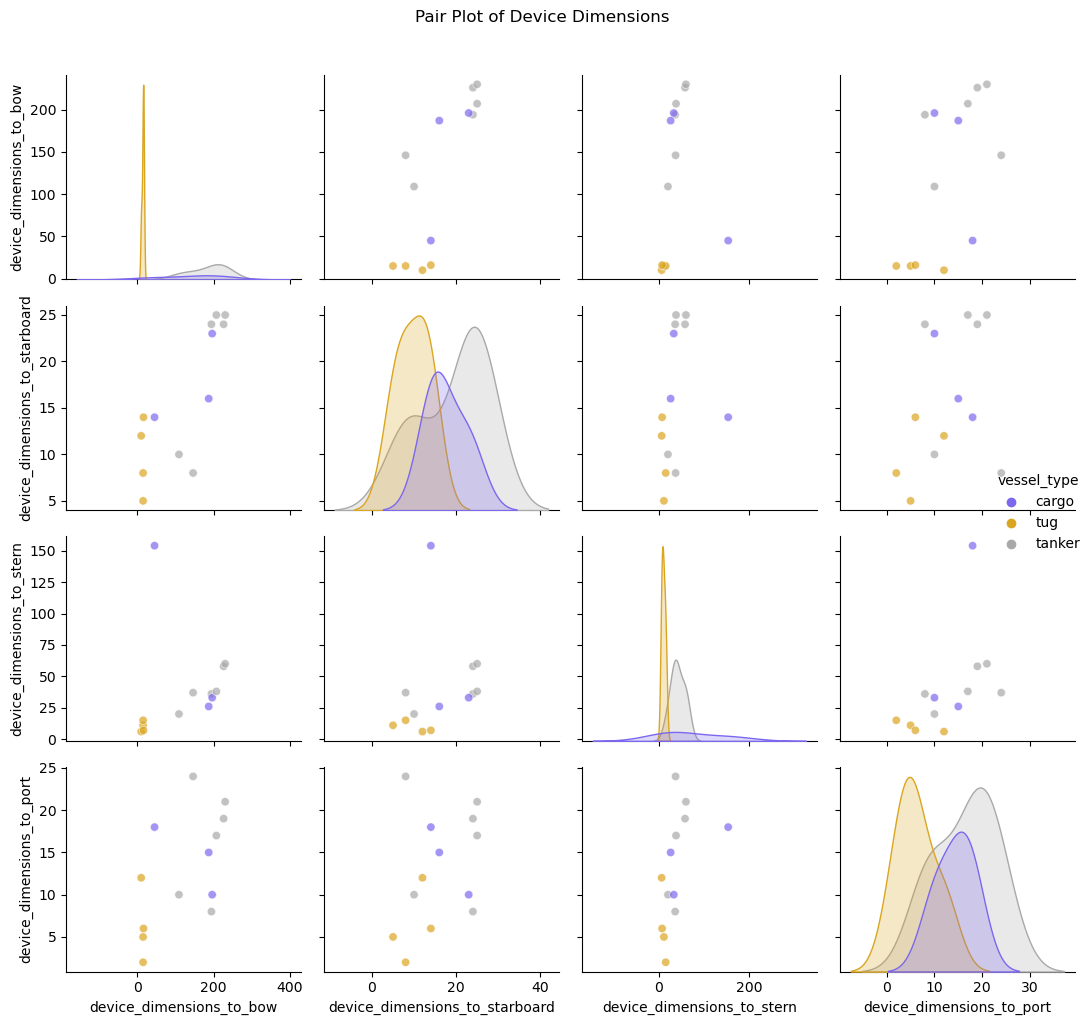

In [85]:
# List of device dimensions
device_dimensions = ['device_dimensions_to_bow', 'device_dimensions_to_starboard', 'device_dimensions_to_stern', 'device_dimensions_to_port']

# Create a pair plot
pairplot = sns.pairplot(
    data=aggregated_df,
    vars=device_dimensions,
    hue='vessel_type',  # Color points by vessel type
    palette=custom_colors,  # Custom color palette
    diag_kind='kde',  # Kernel density estimate on diagonal
    plot_kws={'alpha': 0.7},  # Adjust point transparency
    diag_kws={'shade': True},  # Shade KDE plots
)

# Add a title to the pair plot
pairplot.fig.suptitle('Pair Plot of Device Dimensions', y=1.02)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the pair plot
plt.show()